In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from glob import glob 

import pandas as pd

from fastcore.xtras import load_pickle

from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

%matplotlib inline

## Load results

In [25]:
all_out = glob("out/**/*.pkl")

In [26]:
all_out = [load_pickle(p) for p in all_out]

In [27]:
all_out

[{'accuracy': 0.6428571428571429,
  'acc_macro': 0.6428571428571429,
  'racc': 0.6428571428571429,
  'kappa': 0.0,
  'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
  'f1_macro': 0.391304347826087,
  'f1_micro': 0.6428571428571429,
  'frac_valid': 1.0,
  'all_y_true': (#56) [1,1,0,1,1,0,1,1,1,0...],
  'all_y_pred': (#56) [0,0,0,0,0,0,0,0,0,0...],
  'valid_indices': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55],
  'might_have_rounded_floats': False,
  'true': 0     1
  1     1
  2     0
  3     1
  4     1
  5     0
  6     1
  7     1
  8     1
  9     0
  10    1
  11    0
  12    0
  13    1
  14    0
  15    0
  16    0
  17    0
  18    0
  19

In [28]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out: 
    try:
        res = {
            'train_size': out['train_size'],
            'frac_valid': out['frac_valid'],
            'accuracy': out['accuracy'],
            'f1_macro': out['f1_macro'],
            'f1_micro': out['f1_micro'],
            'kappa': out['kappa'],
            "num_classes": out['num_class'],
            "representation": out['representation']
        }
        extracted_res.append(res)
    except KeyError as e:
        print(e)
        pass

    xgb_res = {
        'train_size': out['train_size'], 
        'accuracy': out['xgb']['accuracy'], 
        'f1_macro': out['xgb']['f1_macro'],
        'f1_micro': out['xgb']['f1_micro'],
        'kappa': out['xgb']['kappa'],
        "num_classes": out['num_class']
    }

    tabpfn_res = {
        'train_size': out['train_size'], 
        'accuracy': out['tabpfn']['accuracy'], 
        'f1_macro': out['tabpfn']['f1_macro'],
        'f1_micro': out['tabpfn']['f1_micro'],
        'kappa': out['tabpfn']['kappa'],
        "num_classes": out['num_class']
    }

    
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

'representation'


In [29]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [30]:
xgboost_res

,train_size,accuracy,f1_macro,f1_micro,kappa,num_classes
0,10,0.732143,0.732057,0.732143,0.500000,2
1,10,0.553571,0.356322,0.553571,0.000000,2
2,10,0.303571,0.116438,0.303571,0.000000,5
3,10,0.392857,0.112821,0.392857,0.000000,5
4,10,0.875000,0.854545,0.875000,0.709199,2
5,10,0.875000,0.854545,0.875000,0.709199,2


In [31]:
grouped_res = res.groupby(['num_classes', "representation", 'train_size']).agg(['mean', 'std'])

In [32]:
grouped_xgboost_res = xgboost_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [33]:
grouped_tabpfn_res = tabpfn_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [34]:
grouped_res.loc[2,:]

frac_valid      accuracy      f1_macro      \
                                mean std      mean std      mean std   
representation train_size                                              
InChI          10                1.0 NaN  0.642857 NaN  0.391304 NaN   
SELFIES        10                1.0 NaN  0.428571 NaN  0.409750 NaN   
SMILES         10                1.0 NaN  0.625000 NaN  0.548907 NaN   

                           f1_micro         kappa      
                               mean std      mean std  
representation train_size                              
InChI          10          0.642857 NaN  0.000000 NaN  
SELFIES        10          0.428571 NaN  0.117241 NaN  
SMILES         10          0.625000 NaN  0.098160 NaN

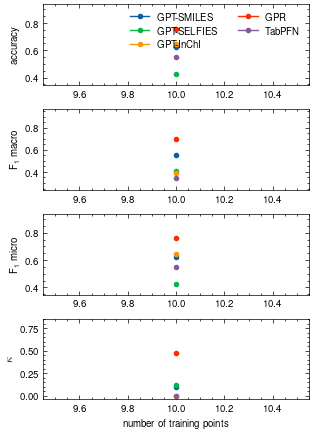

In [35]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[2, 'SMILES', :].index,
        grouped_res.loc[2, 'SMILES', :][metric]['mean'],
        marker='o',
        label='GPT-SMILES',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'SMILES', :].index,
        grouped_res.loc[2, 'SMILES', :][metric]['mean'] - grouped_res.loc[2, 'SMILES', :][metric]['std'],
        grouped_res.loc[2, 'SMILES', :][metric]['mean'] + grouped_res.loc[2, 'SMILES', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[2, 'SELFIES', :].index,
        grouped_res.loc[2, 'SELFIES', :][metric]['mean'],
        marker='o',
        label='GPT-SELFIES',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'SELFIES', :].index,
        grouped_res.loc[2, 'SELFIES', :][metric]['mean'] - grouped_res.loc[2, 'SELFIES', :][metric]['std'],
        grouped_res.loc[2, 'SELFIES', :][metric]['mean'] + grouped_res.loc[2, 'SELFIES', :][metric]['std'],
        alpha=0.2,
    )


    ax[i].plot(
        grouped_res.loc[2, 'InChI', :].index,
        grouped_res.loc[2, 'InChI', :][metric]['mean'],
        marker='o',
        label='GPT-InChI',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'InChI', :].index,
        grouped_res.loc[2, 'InChI', :][metric]['mean'] - grouped_res.loc[2, 'InChI', :][metric]['std'],
        grouped_res.loc[2, 'InChI', :][metric]['mean'] + grouped_res.loc[2, 'InChI', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'],
        marker='o',
        label='GPR'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'] - grouped_xgboost_res.loc[2,:][metric]['std'],
        grouped_xgboost_res.loc[2,:][metric]['mean'] + grouped_xgboost_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'] - grouped_tabpfn_res.loc[2,:][metric]['std'],
        grouped_tabpfn_res.loc[2,:][metric]['mean'] + grouped_tabpfn_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

ax[-1].set_xlabel('number of training points')
ax[0].legend(ncols=2)

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')

fig.tight_layout()
fig.savefig('solubility-classification_results_binary.pdf', bbox_inches='tight')

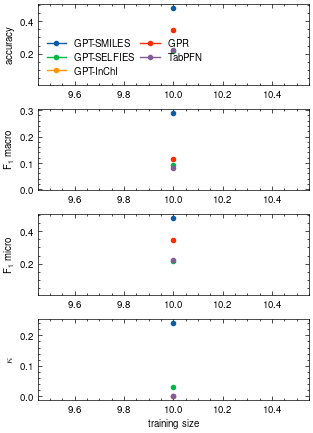

In [36]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[5, 'SMILES', :].index,
        grouped_res.loc[5, 'SMILES', :][metric]['mean'],
        marker='o',
        label='GPT-SMILES',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'SMILES', :].index,
        grouped_res.loc[5, 'SMILES', :][metric]['mean'] - grouped_res.loc[5, 'SMILES', :][metric]['std'],
        grouped_res.loc[5, 'SMILES', :][metric]['mean'] + grouped_res.loc[5, 'SMILES', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, 'SELFIES', :].index,
        grouped_res.loc[5, 'SELFIES', :][metric]['mean'],
        marker='o',
        label='GPT-SELFIES',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'SELFIES', :].index,
        grouped_res.loc[5, 'SELFIES', :][metric]['mean'] - grouped_res.loc[5, 'SELFIES', :][metric]['std'],
        grouped_res.loc[5, 'SELFIES', :][metric]['mean'] + grouped_res.loc[5, 'SELFIES', :][metric]['std'],
        alpha=0.2,
    )


    ax[i].plot(
        grouped_res.loc[5, 'InChI', :].index,
        grouped_res.loc[5, 'InChI', :][metric]['mean'],
        marker='o',
        label='GPT-InChI',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'InChI', :].index,
        grouped_res.loc[5, 'InChI', :][metric]['mean'] - grouped_res.loc[5, 'InChI', :][metric]['std'],
        grouped_res.loc[5, 'InChI', :][metric]['mean'] + grouped_res.loc[5, 'InChI', :][metric]['std'],
        alpha=0.2,
    )

    
    ax[i].plot(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'],
        marker='o',
        label='GPR'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'] - grouped_xgboost_res.loc[5,:][metric]['std'],
        grouped_xgboost_res.loc[5,:][metric]['mean'] + grouped_xgboost_res.loc[5,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'] - grouped_tabpfn_res.loc[5,:][metric]['std'],
        grouped_tabpfn_res.loc[5,:][metric]['mean'] + grouped_tabpfn_res.loc[5,:][metric]['std'],
        alpha=0.2,
    )

ax[-1].set_xlabel('training size')
ax[0].legend(ncols=2, columnspacing=.5)

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')

fig.tight_layout()
fig.savefig('solubility-classification_results_5_class.pdf', bbox_inches='tight')